# XGBoost

In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Import data
from os.path import dirname, join
from pathlib import Path

## Functions

In [2]:
def File_path(foldername,filename):
    ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
    data_PATH = join(ROOT_DIR[:-16],foldername,filename)  # requires `import os`
    return data_PATH
# Merging two lists with unique values in return
def dMerger(l1,l2):
    container = []
    container = l1.copy()
    for data in l2:
        if data not in container:
            container.append(data)
    return container 

# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
# colUniq(data_tier2)

# Normalizing Confusion Matrix
def matNorm (rawMat):
    test_m = rawMat.copy()
    row_sums = test_m.sum(axis=1)
    new_matrix = test_m / row_sums[:, np.newaxis]
    return new_matrix

## Loading Train, Val, Test

In [3]:
data_cleaned = pd.read_csv(File_path('Train_Test_Val','data_cleaned.csv'))

X_train_train = pd.read_csv(File_path('Train_Test_Val','X_train_train.csv'))
y_train_train = pd.read_csv(File_path('Train_Test_Val','y_train_train.csv'))

X_train_val = pd.read_csv(File_path('Train_Test_Val','X_train_val.csv'))
y_train_val = pd.read_csv(File_path('Train_Test_Val','y_train_val.csv'))

X_test_test = pd.read_csv(File_path('Train_Test_Val','X_test.csv'))
y_test_test = pd.read_csv(File_path('Train_Test_Val','y_test.csv'))

In [4]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

type_cleaned  path  type  classes  floor_index  num_sides  area  \
2       CarPort   279   279      279          279        279   279   
6        Garage   414   414      414          414        414   414   
4        Dining   954   954      954          954        954   954   
12      Utility  1489  1489     1489         1489       1489  1489   
11      Storage  1953  1953     1953         1953       1953  1953   
10         Room  2116  2116     2116         2116       2116  2116   
3        Closet  3041  3041     3041         3041       3041  3041   
8    LivingRoom  4428  4428     4428         4428       4428  4428   
7       Kitchen  4548  4548     4548         4548       4548  4548   
5         Entry  6050  6050     6050         6050       6050  6050   
0          Bath  7288  7288     7288         7288       7288  7288   
9       Outdoor  7852  7852     7852         7852       7852  7852   
1       Bedroom  7993  7993     7993         7993       7993  7993   

    proportion_floor_area  perimeter  compactness  ...  contains_Sink  \
2                     279        279          279  ...            279   
6                     414        414          414  ...            414   
4                     954        954          954  ...            954   
12                   1489       1489         1489  ...           1489   
11                   1953       1953         1953  ...           1953   
10                   2116       2116         2116  ...           2116   
3                    3041       3041         3041  ...           3041   
8                    4428       4428         4428  ...           4428   
7                    4548       4548         4548  ...           4548   
5                    6050       6050         6050  ...           6050   
0                    7288       7288         7288  ...           7288   
9                    7852       7852         7852  ...           7852   
1                    7993       7993         7993  ...           7993   

    contains_SpaceForAppliance  contains_Stove  contains_Toilet  \
2                          279             279              279   
6                          414             414              414   
4                          954             954              954   
12                        1489            1489             1489   
11                        1953            1953             1953   
10                        2116            2116             2116   
3                         3041            3041             3041   
8                         4428            4428             4428   
7                         4548            4548             4548   
5                         6050            6050             6050   
0                         7288            7288             7288   
9                         7852            7852             7852   
1                         7993            7993             7993   

    contains_TumbleDryer  contains_Urinal  contains_WallCabinet  \
2                    279              279                   279   
6                    414              414                   414   
4                    954              954                   954   
12                  1489             1489                  1489   
11                  1953             1953                  1953   
10                  2116             2116                  2116   
3                   3041             3041                  3041   
8                   4428             4428                  4428   
7                   4548             4548                  4548   
5                   6050             6050                  6050   
0                   7288             7288                  7288   
9                   7852             7852                  7852   
1                   7993             7993                  7993   

    contains_WashingMachine  contains_WaterTap  exclude  
2                       279                279      279  
6    

In [5]:
print('X_Train')
print(X_train_train.info())
print('\n')
print('y_Train')
print(y_train_train['type_cleaned'].unique(),len(y_train_val))
print('\n')
print('X_val')
print(X_train_val.info())
print('\n')
print('y_val')
print(y_train_val['type_cleaned'].unique(), len(y_train_val))

X_Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27106 entries, 0 to 27105
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 21.5 MB
None


y_Train
['Closet' 'Bedroom' 'Room' 'Storage' 'Outdoor' 'Kitchen' 'Dining' 'Bath'
 'LivingRoom' 'Entry' 'Utility' 'Garage' 'CarPort'] 6777


X_val
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6777 entries, 0 to 6776
Columns: 104 entries, floor_index to contains_WaterTap
dtypes: float64(5), int64(99)
memory usage: 5.4 MB
None


y_val
['Outdoor' 'Dining' 'Bedroom' 'Entry' 'Bath' 'Room' 'LivingRoom' 'Kitchen'
 'Closet' 'Utility' 'Storage' 'Garage' 'CarPort'] 6777


## Creating Feature Groups

In [6]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = []
tier_spc = []
tier_con = []
for col in X_train_train.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)

tier_2a = dMerger(tier_spc,tier_con)
tier_2b = dMerger(tier_spc,tier_fur)

col_select = {
    'fur' : tier_fur,
    'con' : tier_con,
    'spc' : tier_spc,
    'spc_con' : tier_2a,
    'spc_fur' : tier_2b 
            } 


In [7]:
len_spc = len(col_select['spc'])
len_con = len(col_select['con'])
len_fur = len(col_select['fur'])
print('fur:',len_fur,'con:',len_con,'spc:',len_spc)
print('total features:',sum([len_fur,len_con,len_spc]), 'Should be:',len(X_train_train.columns))

fur: 32 con: 58 spc: 14
total features: 104 Should be: 104


## Define Paths

In [8]:
# Import data
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
# data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
# print(data_PATH)
res_PATH = join(ROOT_DIR[:-16],"CSV")
img_PATH = join(ROOT_DIR[:-16],"Charts_Graphs")
print(res_PATH)
print(img_PATH)

c:\Spring 2021\Studio Lab II\arch7211-spring2021\CSV
c:\Spring 2021\Studio Lab II\arch7211-spring2021\Charts_Graphs


## Tier 1

In [9]:
# col_select = {
#     'fur' : tier_fur,
#     'con' : tier_con,
#     'spc' : tier_spc,
#     'spc_con' : tier_2a,
#     'spc_fur' : tier_2b 
#             } 

### 1.a: Space Connectivity

	validation_0-merror:0.41028	validation_1-mlogloss:1.28862	validation_1-merror:0.41375
[320]	validation_0-mlogloss:1.26690	validation_0-merror:0.41024	validation_1-mlogloss:1.28826	validation_1-merror:0.41361
[321]	validation_0-mlogloss:1.26646	validation_0-merror:0.41006	validation_1-mlogloss:1.28792	validation_1-merror:0.41346
[322]	validation_0-mlogloss:1.26602	validation_0-merror:0.41009	validation_1-mlogloss:1.28754	validation_1-merror:0.41346
[323]	validation_0-mlogloss:1.26550	validation_0-merror:0.41013	validation_1-mlogloss:1.28716	validation_1-merror:0.41361
[324]	validation_0-mlogloss:1.26512	validation_0-merror:0.41009	validation_1-mlogloss:1.28684	validation_1-merror:0.41346
[325]	validation_0-mlogloss:1.26470	validation_0-merror:0.40998	validation_1-mlogloss:1.28645	validation_1-merror:0.41346
[326]	validation_0-mlogloss:1.26429	validation_0-merror:0.40998	validation_1-mlogloss:1.28613	validation_1-merror:0.41331
[327]	validation_0-mlogloss:1.26382	validation_0-merror:0.4

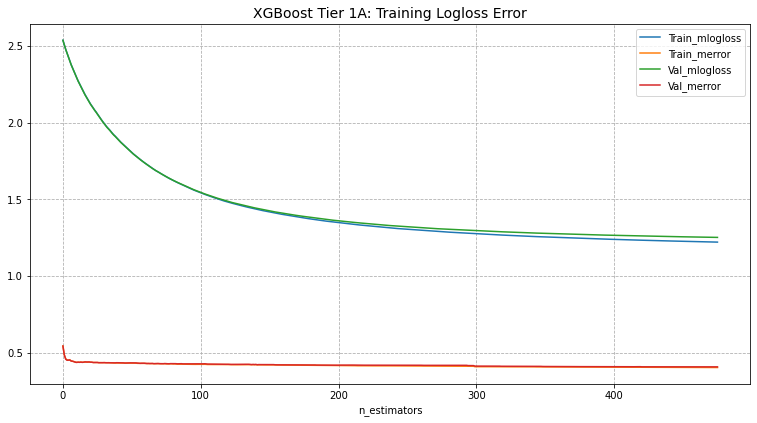

In [24]:
##TIER 1.a 
#Train
X_train = X_train_train[[col for col in col_select['con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['con']]]
y_test = y_test_test['type_cleaned']

#XGB default parameters
model_1a = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 1000,
                    max_depth = 6,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    n_jobs = -1,
                    seed = 27)
print(model_1a)

## Train Model
model_1a.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_1a = model_1a.evals_result()
# Train score : Mean Accuracy
train_score_1a = model_1a.score(X_train,y_train)
print("Tier 1A Training score: ",train_score_1a)

best_iteration_1a = model_1a.get_booster().best_ntree_limit
y_pred_1a = model_1a.predict(X_test, ntree_limit=best_iteration_1a)
print("Best Iteration: ",best_iteration_1a)
# evaluate predictions
accuracy_1a = accuracy_score(y_test, y_pred_1a)
print("Accuracy: %.2f%%" % (accuracy_1a * 100.0))

# Report Classification Results
file_name = "XGB_Tier1A_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1a,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1a))

#Mlogloss and Merror plot
fig1a = plt.figure(figsize=(10,5))
ax1a = fig1a.add_axes([.1,.1,1,1])
file_name = "XGB_Tier1A_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax1a.plot(evals_result_1a.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax1a.plot(evals_result_1a.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax1a.plot(evals_result_1a.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax1a.plot(evals_result_1a.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax1a.set_title('XGBoost Tier 1A: Training Logloss Error', fontsize = 14)
ax1a.legend(loc=1)
ax1a.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")

fig1a.savefig(fig_PATH)
plt.show()

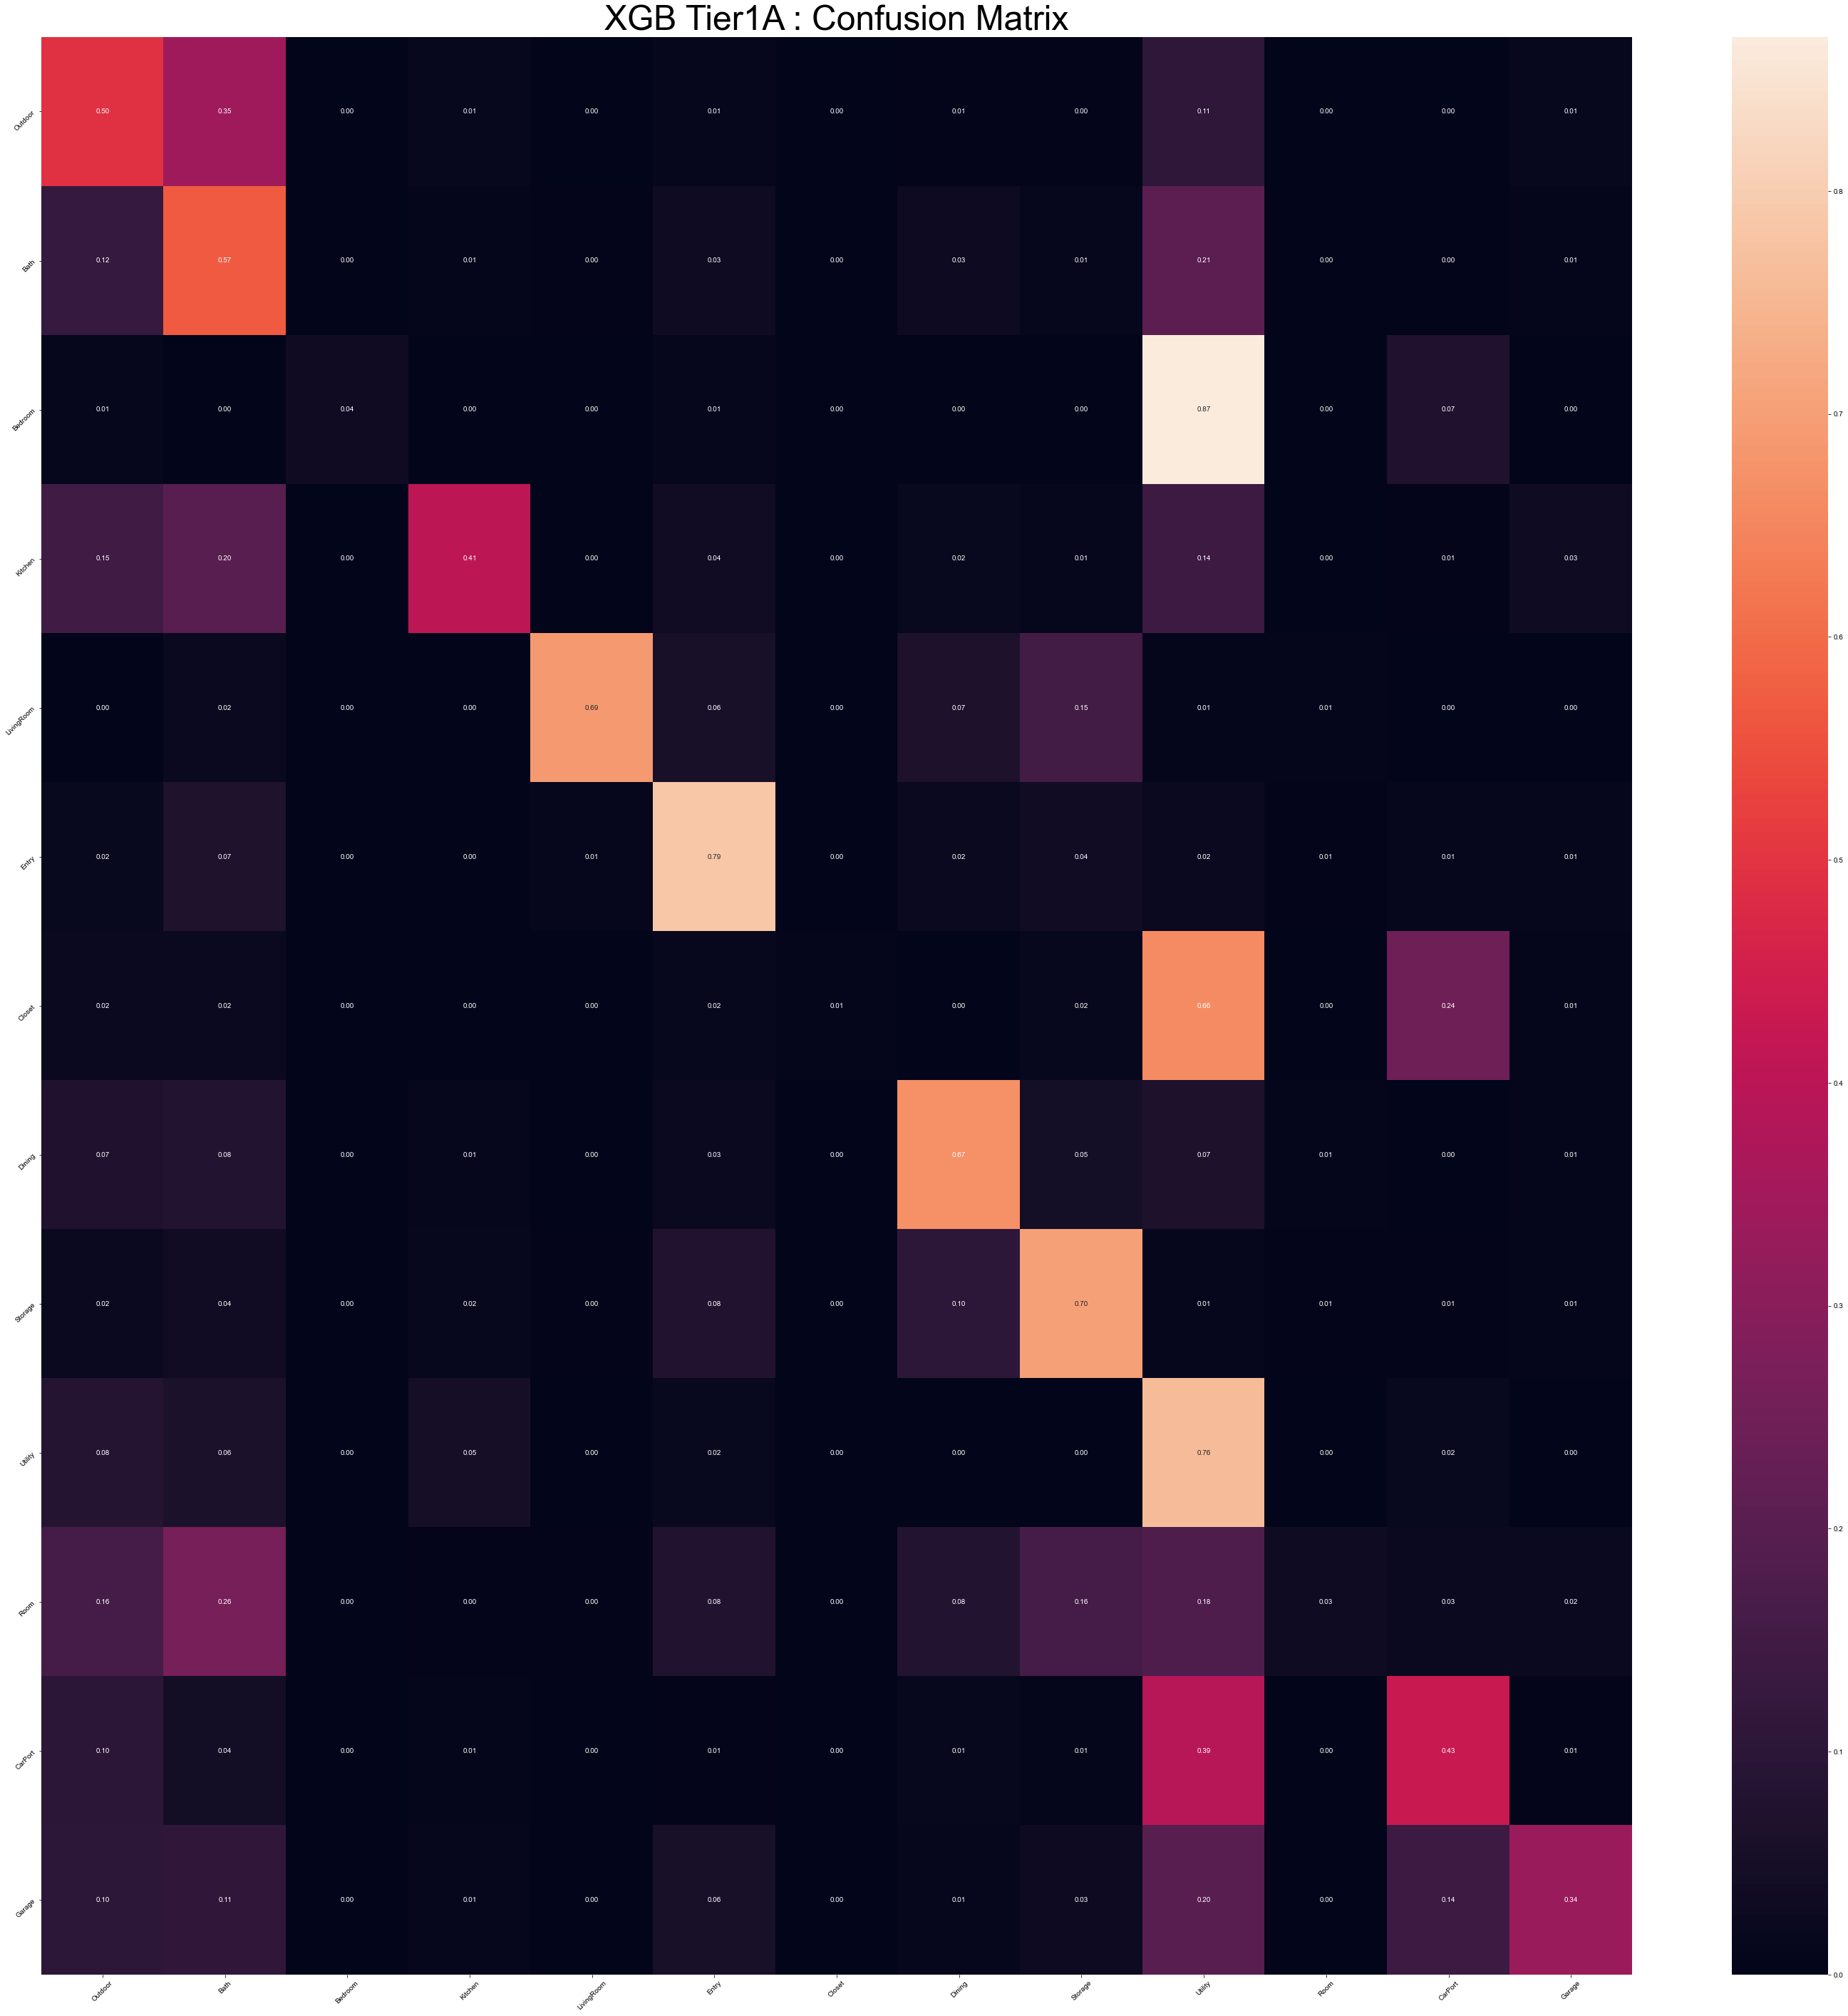

In [25]:
# Confusion Matrix
file_name = "XGB_Tier1A_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_1a)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_1a).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
sns.set(font_scale=4)
plt.title('XGB Tier1A : Confusion Matrix')
plt.savefig(fig_PATH, dpi=300)
plt.show()

## Furniture Features

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, seed=27, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)
[0]	validation_0-mlogloss:2.52529	validation_0-merror:0.49816	validation_1-mlogloss:2.52615	validation_1-merror:0.50848
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object;

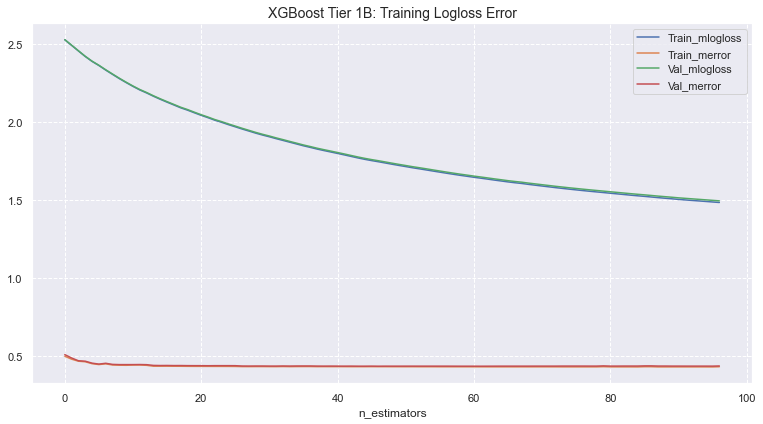

In [14]:
##TIER 1.b 
#Train
X_train = X_train_train[[col for col in col_select['fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['fur']]]
y_test = y_test_test['type_cleaned']

#XGB default parameters
model_1b = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 1000,
                    max_depth = 6,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    n_jobs = -1,
                    seed = 27)
print(model_1b)

## Train Model
model_1b.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_1b = model_1b.evals_result()
# Train score : Mean Accuracy
train_score_1b = model_1b.score(X_train,y_train)
print("Tier 1B Training score: ",train_score_1b)

best_iteration_1b = model_1b.get_booster().best_ntree_limit
y_pred_1b = model_1b.predict(X_test, ntree_limit=best_iteration_1b)
print("Best Iteration: ",best_iteration_1b)
# evaluate predictions
accuracy_1b = accuracy_score(y_test, y_pred_1b)
print("Accuracy: %.2f%%" % (accuracy_1b * 100.0))

# Report Classification Results
file_name = "XGB_Tier1B_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1b,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1b))

#Mlogloss and Merror plot
fig1b = plt.figure(figsize=(10,5))
ax1b = fig1b.add_axes([.1,.1,1,1])
file_name = "XGB_Tier1B_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax1b.plot(evals_result_1b.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax1b.plot(evals_result_1b.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax1b.plot(evals_result_1b.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax1b.plot(evals_result_1b.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax1b.set_title('XGBoost Tier 1B: Training Logloss Error', fontsize = 14)
ax1b.legend(loc=1)
ax1b.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")
sns.set(font_scale=1)
fig1b.savefig(fig_PATH)
plt.show()


In [30]:
# file_name = "XGB_Tier1B_ConfMat.png"
# fig_PATH = join(img_PATH,file_name)
# cMat = confusion_matrix(y_test,y_pred_1b)
# df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_1b).fillna(0).unique())
# plt.figure(figsize= (50,50))
# cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
# cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
# sns.set(font_scale=4)
# plt.title('XGB Tier1B : Confusion Matrix')
# plt.savefig(fig_PATH, dpi=300)
# plt.show()

## 1.C: Space Properties

	validation_0-merror:0.17225	validation_1-mlogloss:0.72286	validation_1-merror:0.20540
[184]	validation_0-mlogloss:0.62371	validation_0-merror:0.17236	validation_1-mlogloss:0.72154	validation_1-merror:0.20511
[185]	validation_0-mlogloss:0.62200	validation_0-merror:0.17221	validation_1-mlogloss:0.72021	validation_1-merror:0.20511
[186]	validation_0-mlogloss:0.62019	validation_0-merror:0.17199	validation_1-mlogloss:0.71882	validation_1-merror:0.20481
[187]	validation_0-mlogloss:0.61848	validation_0-merror:0.17181	validation_1-mlogloss:0.71750	validation_1-merror:0.20452
[188]	validation_0-mlogloss:0.61670	validation_0-merror:0.17166	validation_1-mlogloss:0.71623	validation_1-merror:0.20481
[189]	validation_0-mlogloss:0.61505	validation_0-merror:0.17166	validation_1-mlogloss:0.71489	validation_1-merror:0.20496
[190]	validation_0-mlogloss:0.61347	validation_0-merror:0.17159	validation_1-mlogloss:0.71362	validation_1-merror:0.20466
[191]	validation_0-mlogloss:0.61176	validation_0-merror:0.1

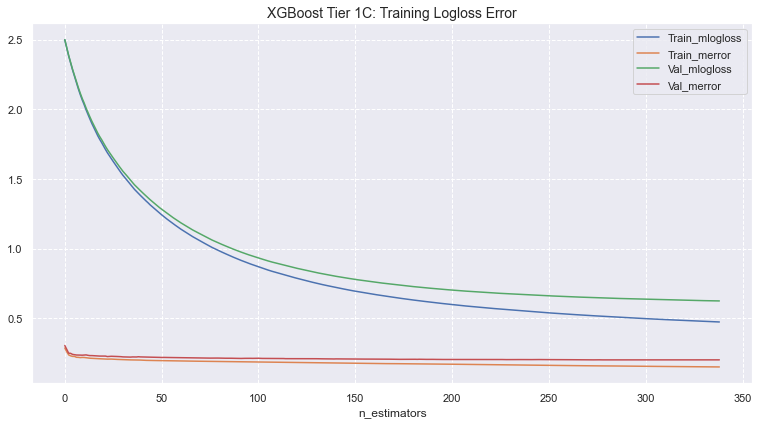

In [13]:
##TIER 1.c 
#Train
X_train = X_train_train[[col for col in col_select['spc']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc']]]
y_test = y_test_test['type_cleaned']

#XGB default parameters
model_1c = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 1000,
                    max_depth = 6,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    n_jobs = -1,
                    seed = 27)
print(model_1c)

## Train Model
model_1c.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_1c = model_1c.evals_result()
# Train score : Mean Accuracy
train_score_1c = model_1c.score(X_train,y_train)
print("Tier 1C Training score: ",train_score_1c)

best_iteration_1c = model_1c.get_booster().best_ntree_limit
y_pred_1c = model_1c.predict(X_test, ntree_limit=best_iteration_1c)
print("Best Iteration: ",best_iteration_1c)
# evaluate predictions
accuracy_1c = accuracy_score(y_test, y_pred_1c)
print("Accuracy: %.2f%%" % (accuracy_1c * 100.0))

# Report Classification Results
file_name = "XGB_Tier1C_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_1c,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_1c))

#Mlogloss and Merror plot
fig1c = plt.figure(figsize=(10,5))
ax1c = fig1c.add_axes([.1,.1,1,1])
file_name = "XGB_Tier1C_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax1c.plot(evals_result_1c.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax1c.plot(evals_result_1c.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax1c.plot(evals_result_1c.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax1c.plot(evals_result_1c.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax1c.set_title('XGBoost Tier 1C: Training Logloss Error', fontsize = 14)
ax1c.legend(loc=1)
ax1c.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")
sns.set(font_scale=1)
fig1c.savefig(fig_PATH)
plt.show()


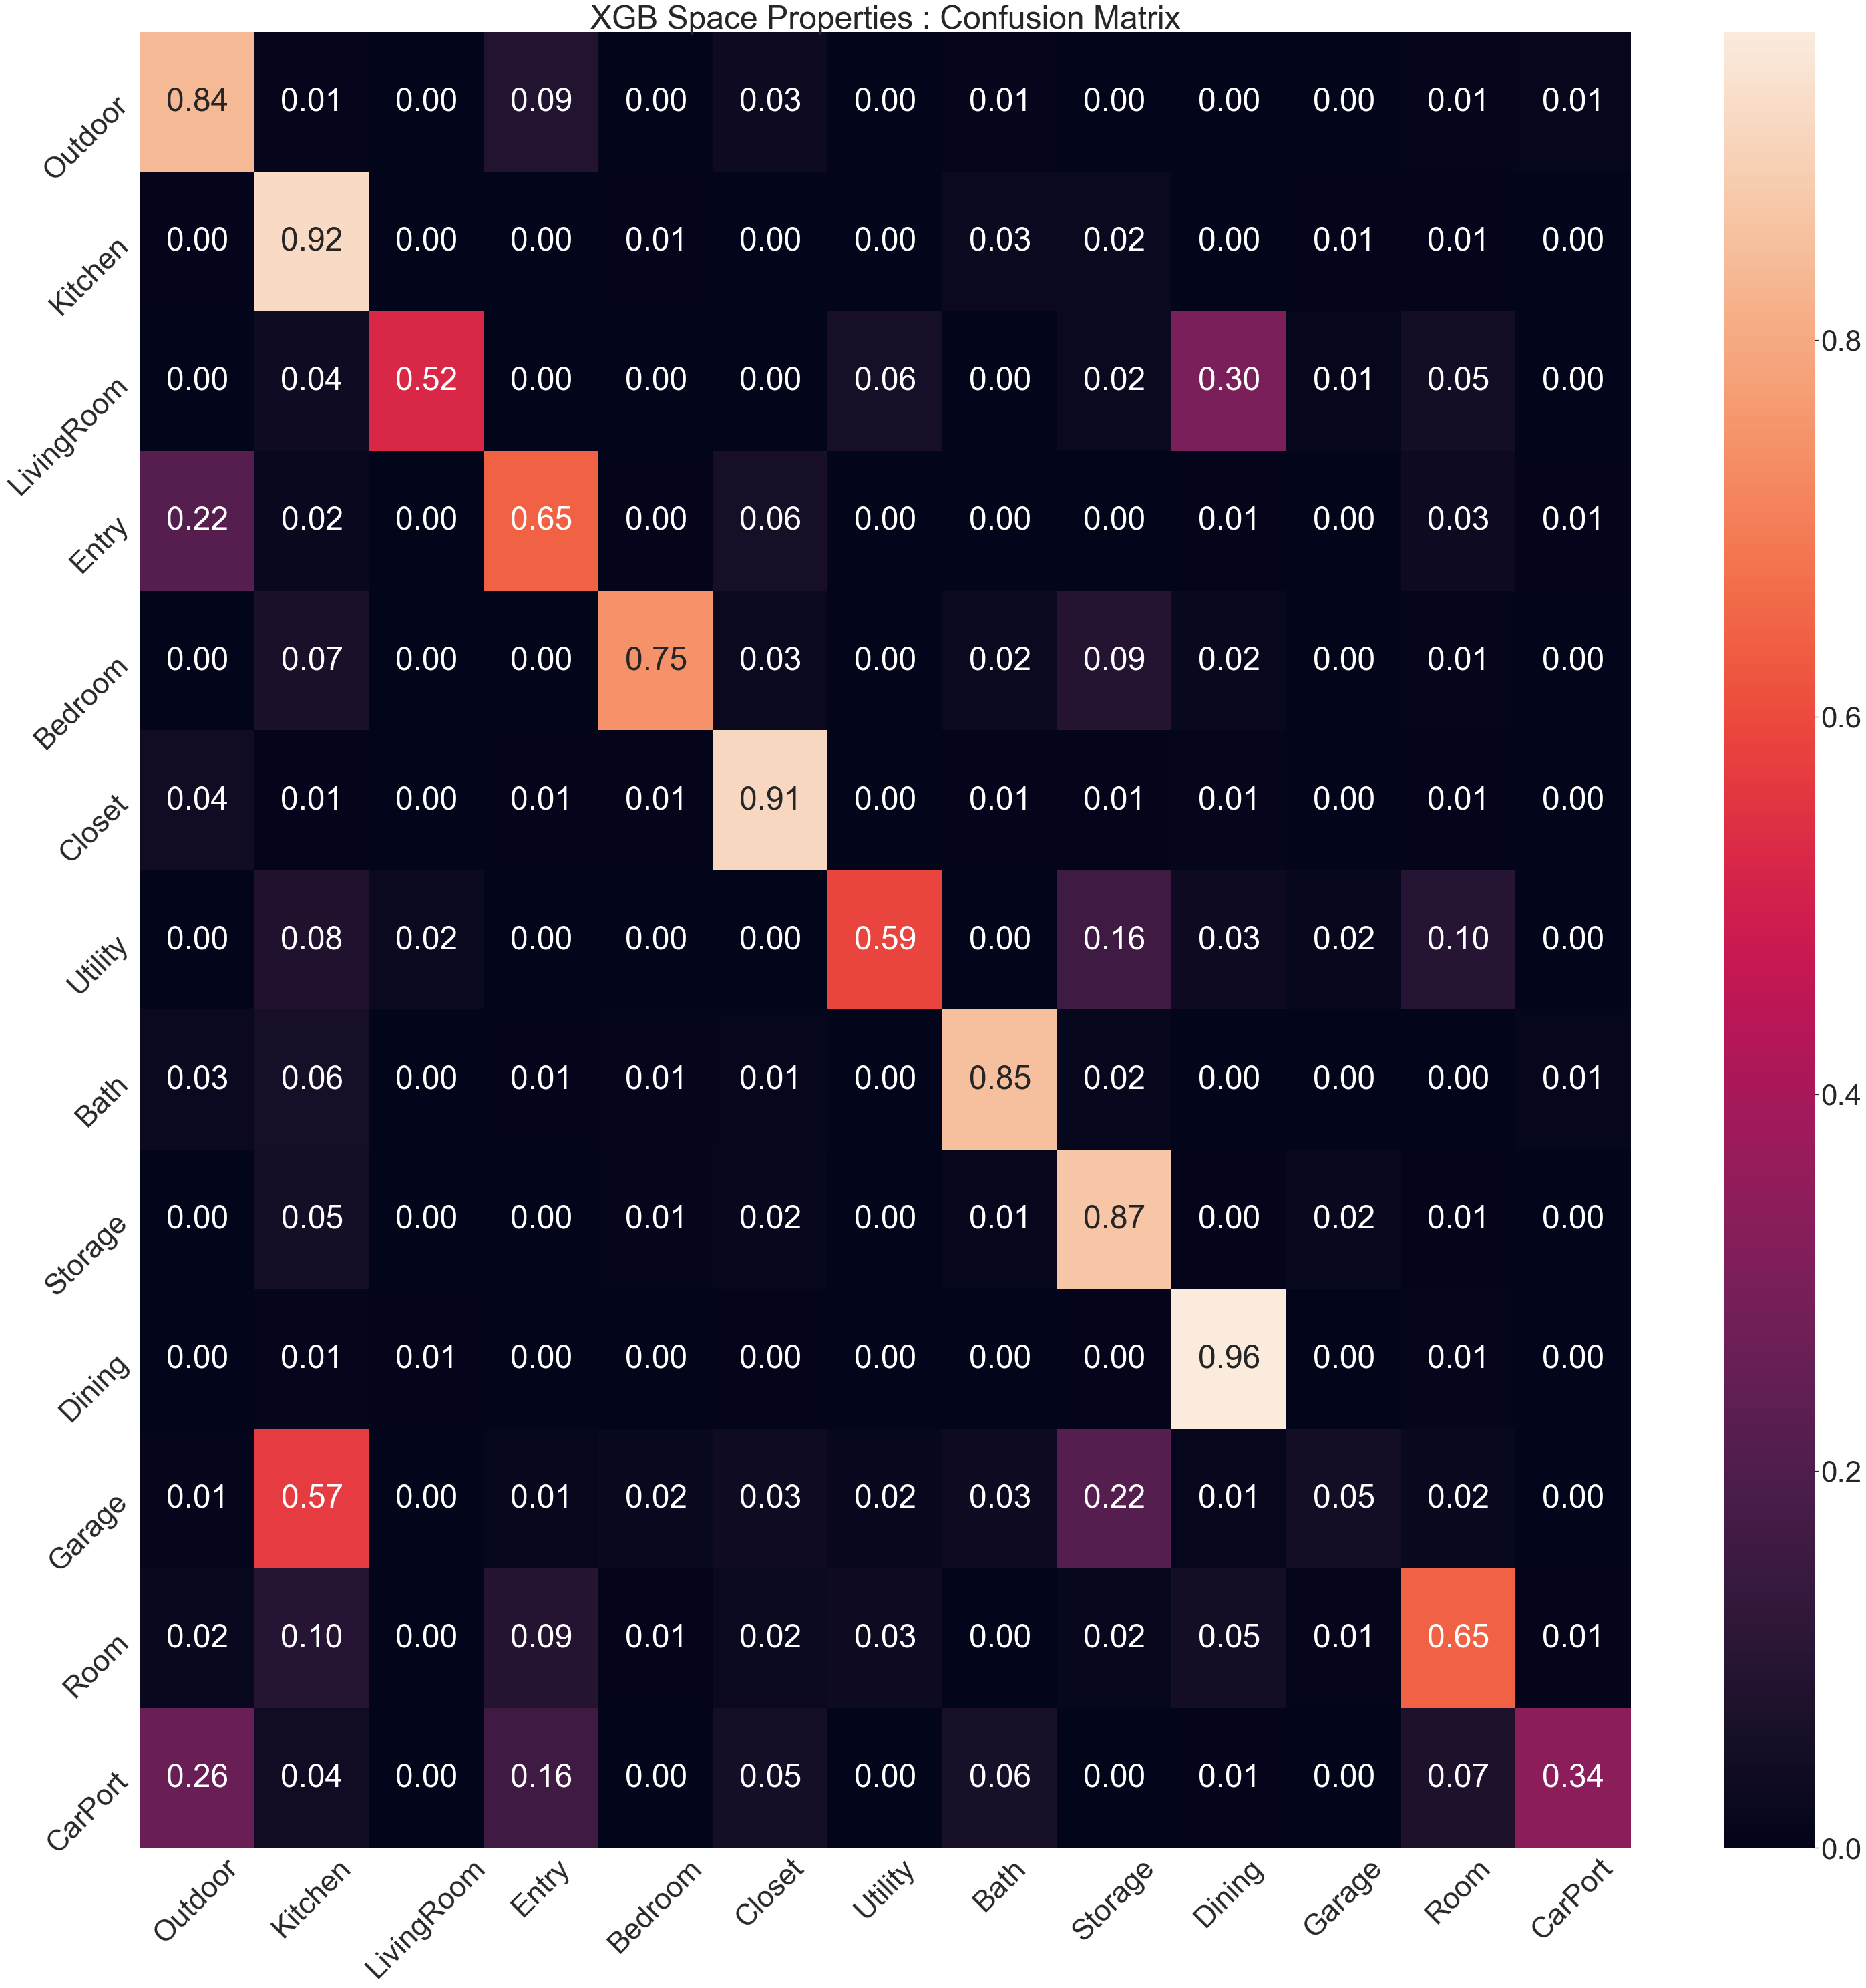

In [34]:
file_name = "XGB_Tier1C_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_1c)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_1c).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('XGB Space Properties : Confusion Matrix')
sns.set(font_scale=4)
plt.savefig(fig_PATH, dpi=300)
plt.show()

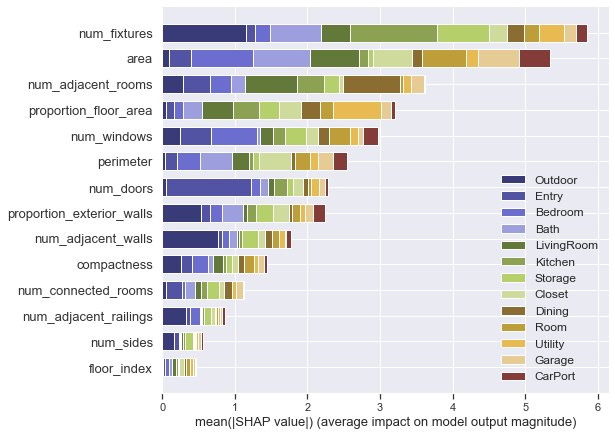

In [12]:
# Feature importance
file_name = "XGB_Tier1C_feat_imp.png"
fig_PATH = join(img_PATH,file_name)
shap_values = shap.TreeExplainer(model_1c).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,
                  plot_type="bar",class_names=model_1c.classes_,
                  title='XGB Space Properties Feature Importance',
                  color = plt.get_cmap("tab20b"))
f.savefig(fig_PATH, bbox_inches='tight', dpi=300)

## Grid Search

In [38]:
#Grid Search based on best sub dataset (between tier1a, 1b, and 1c based on their classification reports)

#Grid Search

#Reproductability
seed = 342
np.random.seed(seed)
#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [5,6,7,None],
    'subsample': [0.6,0.8,0.9,None],
    'colsample_bytree' : [0.6,0.8,0.9,None]
                }
params_fixed = {
    'objective' : 'multi:softprob',
    'n_estimators' : 575,
    'learning_rate' : 0.02,
    'n_jobs' :-1,
    'verbosity' : 1
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring=['f1_macro','accuracy'],return_train_score = True, refit='f1_macro')

In [39]:
fit_params = {
        'eval_set':[(X_train, y_train), (X_val, y_val)],
        'eval_metric':['mlogloss','merror'],
        'early_stopping_rounds':50
                }
bst_grid.fit(X_train,y_train,**fit_params)

lidation_0-mlogloss:0.44196	validation_0-merror:0.14045	validation_1-mlogloss:0.62748	validation_1-merror:0.19861
[286]	validation_0-mlogloss:0.44125	validation_0-merror:0.14023	validation_1-mlogloss:0.62714	validation_1-merror:0.19817
[287]	validation_0-mlogloss:0.44055	validation_0-merror:0.14008	validation_1-mlogloss:0.62686	validation_1-merror:0.19787
[288]	validation_0-mlogloss:0.43984	validation_0-merror:0.13989	validation_1-mlogloss:0.62658	validation_1-merror:0.19802
[289]	validation_0-mlogloss:0.43914	validation_0-merror:0.13978	validation_1-mlogloss:0.62635	validation_1-merror:0.19817
[290]	validation_0-mlogloss:0.43839	validation_0-merror:0.13956	validation_1-mlogloss:0.62611	validation_1-merror:0.19802
[291]	validation_0-mlogloss:0.43761	validation_0-merror:0.13938	validation_1-mlogloss:0.62586	validation_1-merror:0.19773
[292]	validation_0-mlogloss:0.43694	validation_0-merror:0.13927	validation_1-mlogloss:0.62557	validation_1-merror:0.19773
[293]	validation_0-mlogloss:0.43

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=342, subsample=None, tree_method=None,
                          

In [40]:
bst_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=575, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [43]:
# Print best hyper-parameters
print('Best params:',bst_grid.best_params_)
# Save the grid search results
report_PATH = join(ROOT_DIR[:-16],"CSV","XGB_Tier1C_gridsearch.csv")
cv_res_df =pd.DataFrame(bst_grid.cv_results_)
cv_res_df.to_csv(report_PATH)

# Predict by best model
bst_pred = bst_grid.best_estimator_.predict(X_test)

#Evaluate prediction based on best-model
report_PATH = join(ROOT_DIR[:-16],"CSV","XGB_Tier1C_bestparams_classificationReport.csv")
class_report = classification_report(y_test,bst_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,bst_pred))

Best params: {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.6}
              precision    recall  f1-score   support

        Bath       0.80      0.83      0.81      2187
     Bedroom       0.76      0.92      0.83      2398
     CarPort       0.71      0.54      0.61        84
      Closet       0.62      0.65      0.63       912
      Dining       0.72      0.73      0.73       286
       Entry       0.87      0.91      0.89      1815
      Garage       0.64      0.59      0.61       124
     Kitchen       0.88      0.86      0.87      1364
  LivingRoom       0.79      0.87      0.83      1328
     Outdoor       0.95      0.96      0.96      2356
        Room       0.27      0.04      0.06       635
     Storage       0.69      0.65      0.67       586
     Utility       0.72      0.35      0.47       447

    accuracy                           0.81     14522
   macro avg       0.72      0.68      0.69     14522
weighted avg       0.79      0.81      0.79     14522



## Tier 2

### Tier 2.a: Space Properties & Space Connectivity

In [46]:
# Best params: {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.6}

	validation_0-merror:0.09419	validation_1-mlogloss:0.48074	validation_1-merror:0.14918
[327]	validation_0-mlogloss:0.31530	validation_0-merror:0.09400	validation_1-mlogloss:0.48048	validation_1-merror:0.14918
[328]	validation_0-mlogloss:0.31474	validation_0-merror:0.09400	validation_1-mlogloss:0.48027	validation_1-merror:0.14918
[329]	validation_0-mlogloss:0.31411	validation_0-merror:0.09378	validation_1-mlogloss:0.47995	validation_1-merror:0.14918
[330]	validation_0-mlogloss:0.31361	validation_0-merror:0.09371	validation_1-mlogloss:0.47971	validation_1-merror:0.14903
[331]	validation_0-mlogloss:0.31296	validation_0-merror:0.09371	validation_1-mlogloss:0.47948	validation_1-merror:0.14903
[332]	validation_0-mlogloss:0.31242	validation_0-merror:0.09345	validation_1-mlogloss:0.47924	validation_1-merror:0.14889
[333]	validation_0-mlogloss:0.31185	validation_0-merror:0.09315	validation_1-mlogloss:0.47895	validation_1-merror:0.14903
[334]	validation_0-mlogloss:0.31132	validation_0-merror:0.0

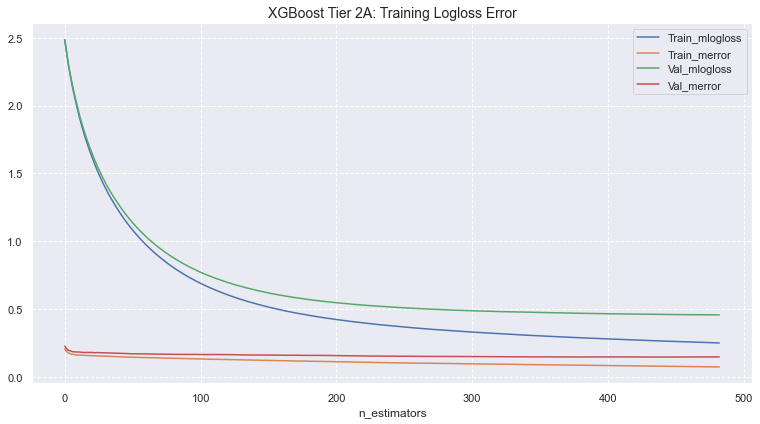

In [49]:
##TIER 2.a: Space Properties & Space Connectivity
#Train
X_train = X_train_train[[col for col in col_select['spc_con']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_con']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_con']]]
y_test = y_test_test['type_cleaned']

# Best params: {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.6}
#XGB default parameters
model_2a = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 575,
                    max_depth = 7,
                    subsample= 0.6,
                    colsample_bytree = 0.8,
                    n_jobs = -1,
                    seed = 27)
print(model_2a)

## Train Model
model_2a.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_2a = model_2a.evals_result()
# Train score : Mean Accuracy
train_score_2a = model_2a.score(X_train,y_train)
print("Tier 2A Training score: ",train_score_2a)

best_iteration_2a = model_2a.get_booster().best_ntree_limit
y_pred_2a = model_2a.predict(X_test, ntree_limit=best_iteration_2a)
print("Best Iteration: ",best_iteration_2a)
# evaluate predictions
accuracy_2a = accuracy_score(y_test, y_pred_2a)
print("Accuracy: %.2f%%" % (accuracy_2a * 100.0))

# Report Classification Results
file_name = "XGB_Tier2a_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_2a,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_2a))

#Mlogloss and Merror plot
fig2a = plt.figure(figsize=(10,5))
ax2a = fig2a.add_axes([.1,.1,1,1])
file_name = "XGB_Tier2a_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax2a.plot(evals_result_2a.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax2a.plot(evals_result_2a.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax2a.plot(evals_result_2a.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax2a.plot(evals_result_2a.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax2a.set_title('XGBoost Tier 2A: Training Logloss Error', fontsize = 14)
ax2a.legend(loc=1)
ax2a.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")
sns.set(font_scale=1)
fig2a.savefig(fig_PATH)
plt.show()

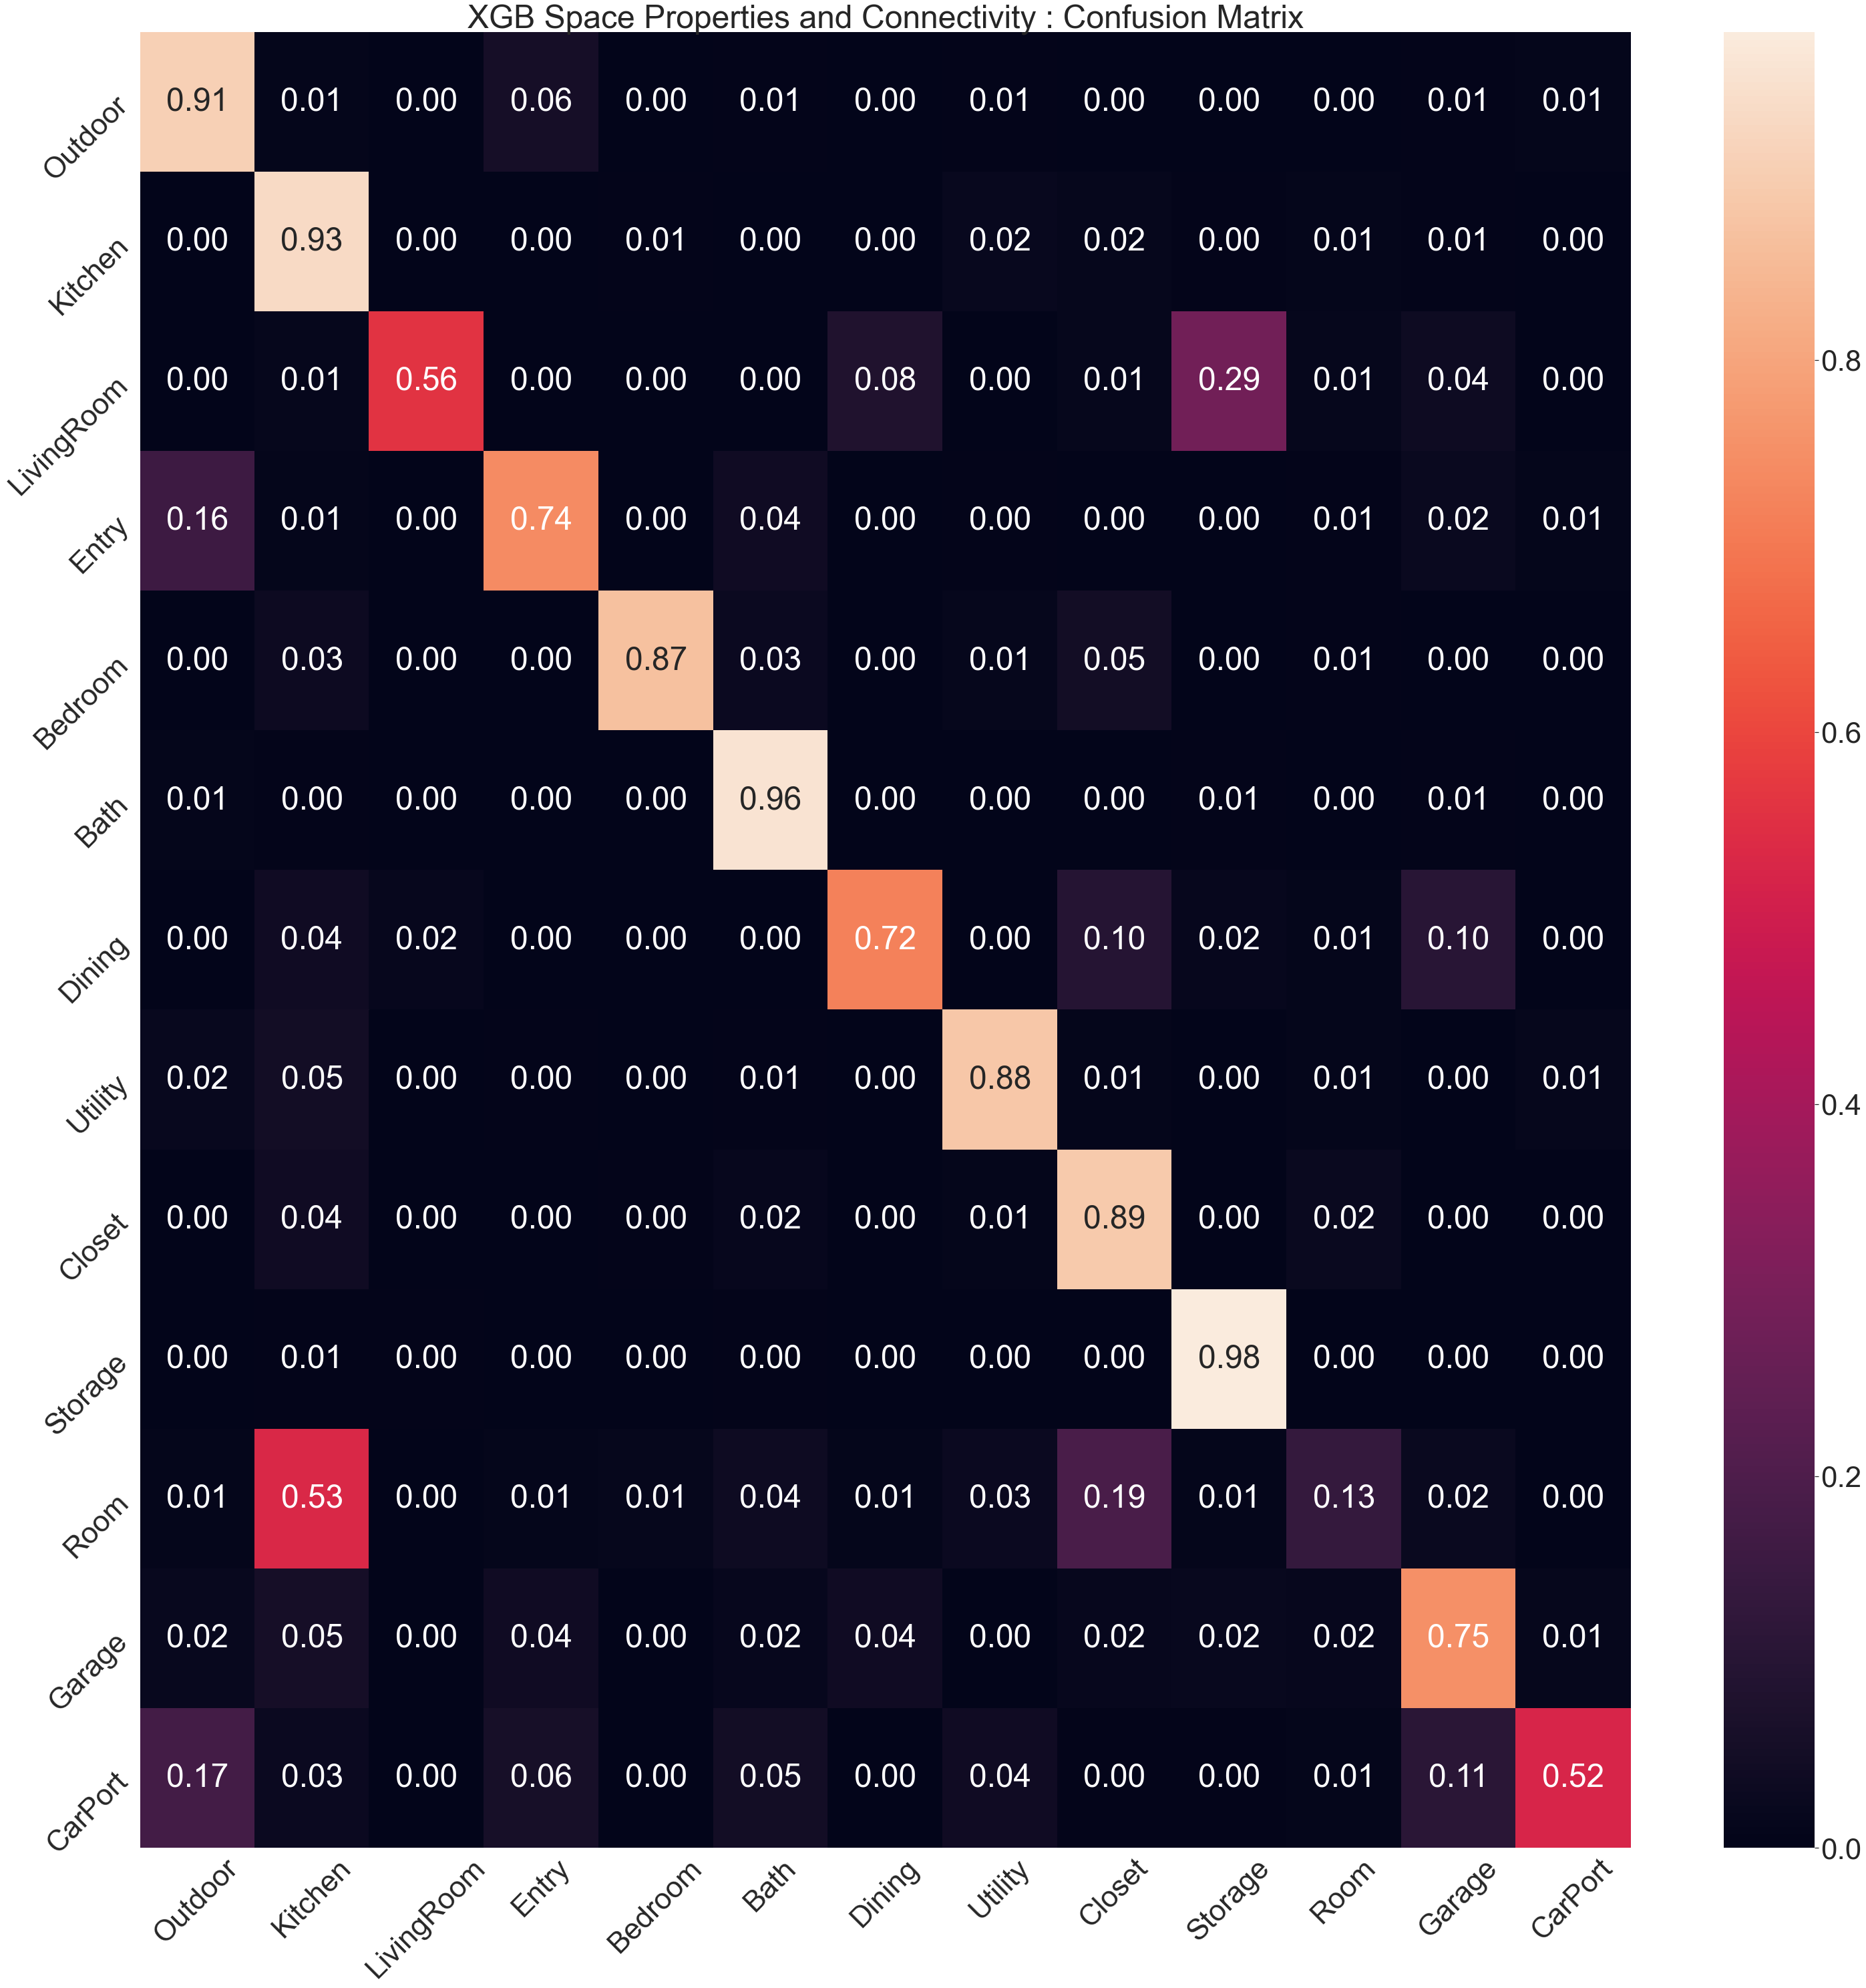

In [51]:
file_name = "XGB_Tier2A_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_2a)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_2a).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('XGB Space Properties and Connectivity : Confusion Matrix')
sns.set(font_scale=4)
plt.savefig(fig_PATH, dpi=300)
plt.show()

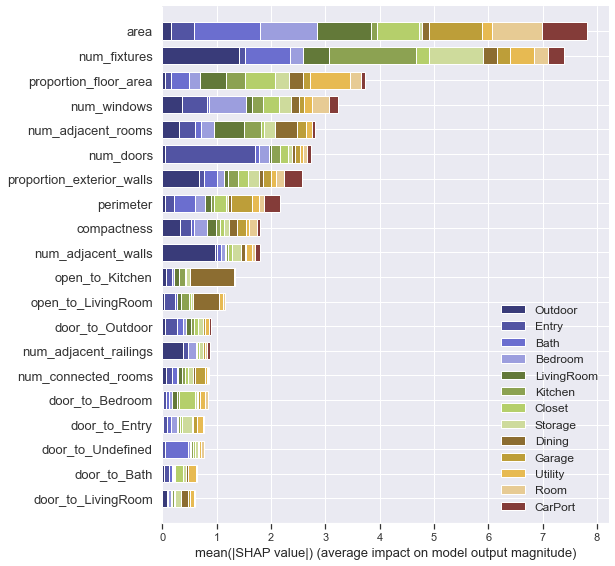

In [52]:
# Feature importance
file_name = "XGB_Tier2A_feat_imp.png"
fig_PATH = join(img_PATH,file_name)
shap_values = shap.TreeExplainer(model_2a).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,
                  plot_type="bar",class_names=model_2a.classes_,
                  title='XGB Space Properties & Connectivity Feature Importance',
                  color = plt.get_cmap("tab20b"))
f.savefig(fig_PATH, bbox_inches='tight', dpi=300)

	validation_0-merror:0.11064	validation_1-mlogloss:0.55472	validation_1-merror:0.13811
[151]	validation_0-mlogloss:0.46601	validation_0-merror:0.11049	validation_1-mlogloss:0.55301	validation_1-merror:0.13826
[152]	validation_0-mlogloss:0.46385	validation_0-merror:0.11049	validation_1-mlogloss:0.55119	validation_1-merror:0.13826
[153]	validation_0-mlogloss:0.46172	validation_0-merror:0.11038	validation_1-mlogloss:0.54949	validation_1-merror:0.13841
[154]	validation_0-mlogloss:0.45958	validation_0-merror:0.11012	validation_1-mlogloss:0.54771	validation_1-merror:0.13797
[155]	validation_0-mlogloss:0.45745	validation_0-merror:0.11005	validation_1-mlogloss:0.54599	validation_1-merror:0.13797
[156]	validation_0-mlogloss:0.45527	validation_0-merror:0.10994	validation_1-mlogloss:0.54431	validation_1-merror:0.13811
[157]	validation_0-mlogloss:0.45332	validation_0-merror:0.10990	validation_1-mlogloss:0.54264	validation_1-merror:0.13782
[158]	validation_0-mlogloss:0.45128	validation_0-merror:0.1

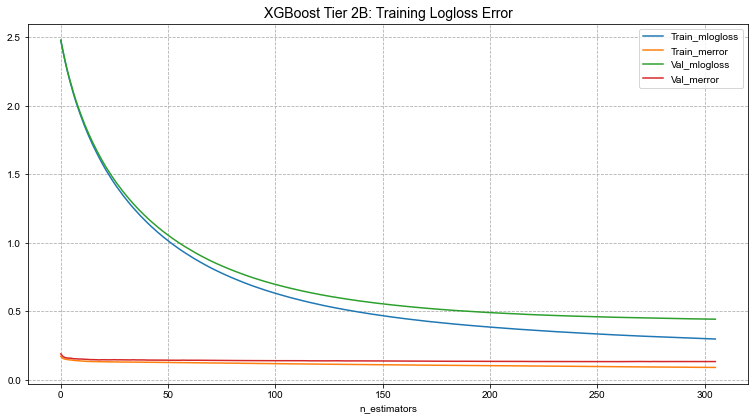

In [10]:
##TIER 2.b
#Train
X_train = X_train_train[[col for col in col_select['spc_fur']]]
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val[[col for col in col_select['spc_fur']]]
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test[[col for col in col_select['spc_fur']]]
y_test = y_test_test['type_cleaned']

# Best params: {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.6}
#XGB default parameters
model_2b = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 575,
                    max_depth = 7,
                    subsample= 0.6,
                    colsample_bytree = 0.8,
                    n_jobs = -1,
                    seed = 27)
print(model_2b)

## Train Model
model_2b.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_2b = model_2b.evals_result()
# Train score : Mean Accuracy
train_score_2b = model_2b.score(X_train,y_train)
print("Tier 2B Training score: ",train_score_2b)

best_iteration_2b = model_2b.get_booster().best_ntree_limit
y_pred_2b = model_2b.predict(X_test, ntree_limit=best_iteration_2b)
print("Best Iteration: ",best_iteration_2b)
# evaluate predictions
accuracy_2b = accuracy_score(y_test, y_pred_2b)
print("Accuracy: %.2f%%" % (accuracy_2b * 100.0))

# Report Classification Results
file_name = "XGB_Tier2b_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_2b,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_2b))

#Mlogloss and Merror plot
fig2b = plt.figure(figsize=(10,5))
ax2b = fig2b.add_axes([.1,.1,1,1])
file_name = "XGB_Tier2b_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax2b.plot(evals_result_2b.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax2b.plot(evals_result_2b.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax2b.plot(evals_result_2b.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax2b.plot(evals_result_2b.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax2b.set_title('XGBoost Tier 2B: Training Logloss Error', fontsize = 14)
ax2b.legend(loc=1)
ax2b.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")
sns.set(font_scale=1)
fig2b.savefig(fig_PATH)
plt.show()

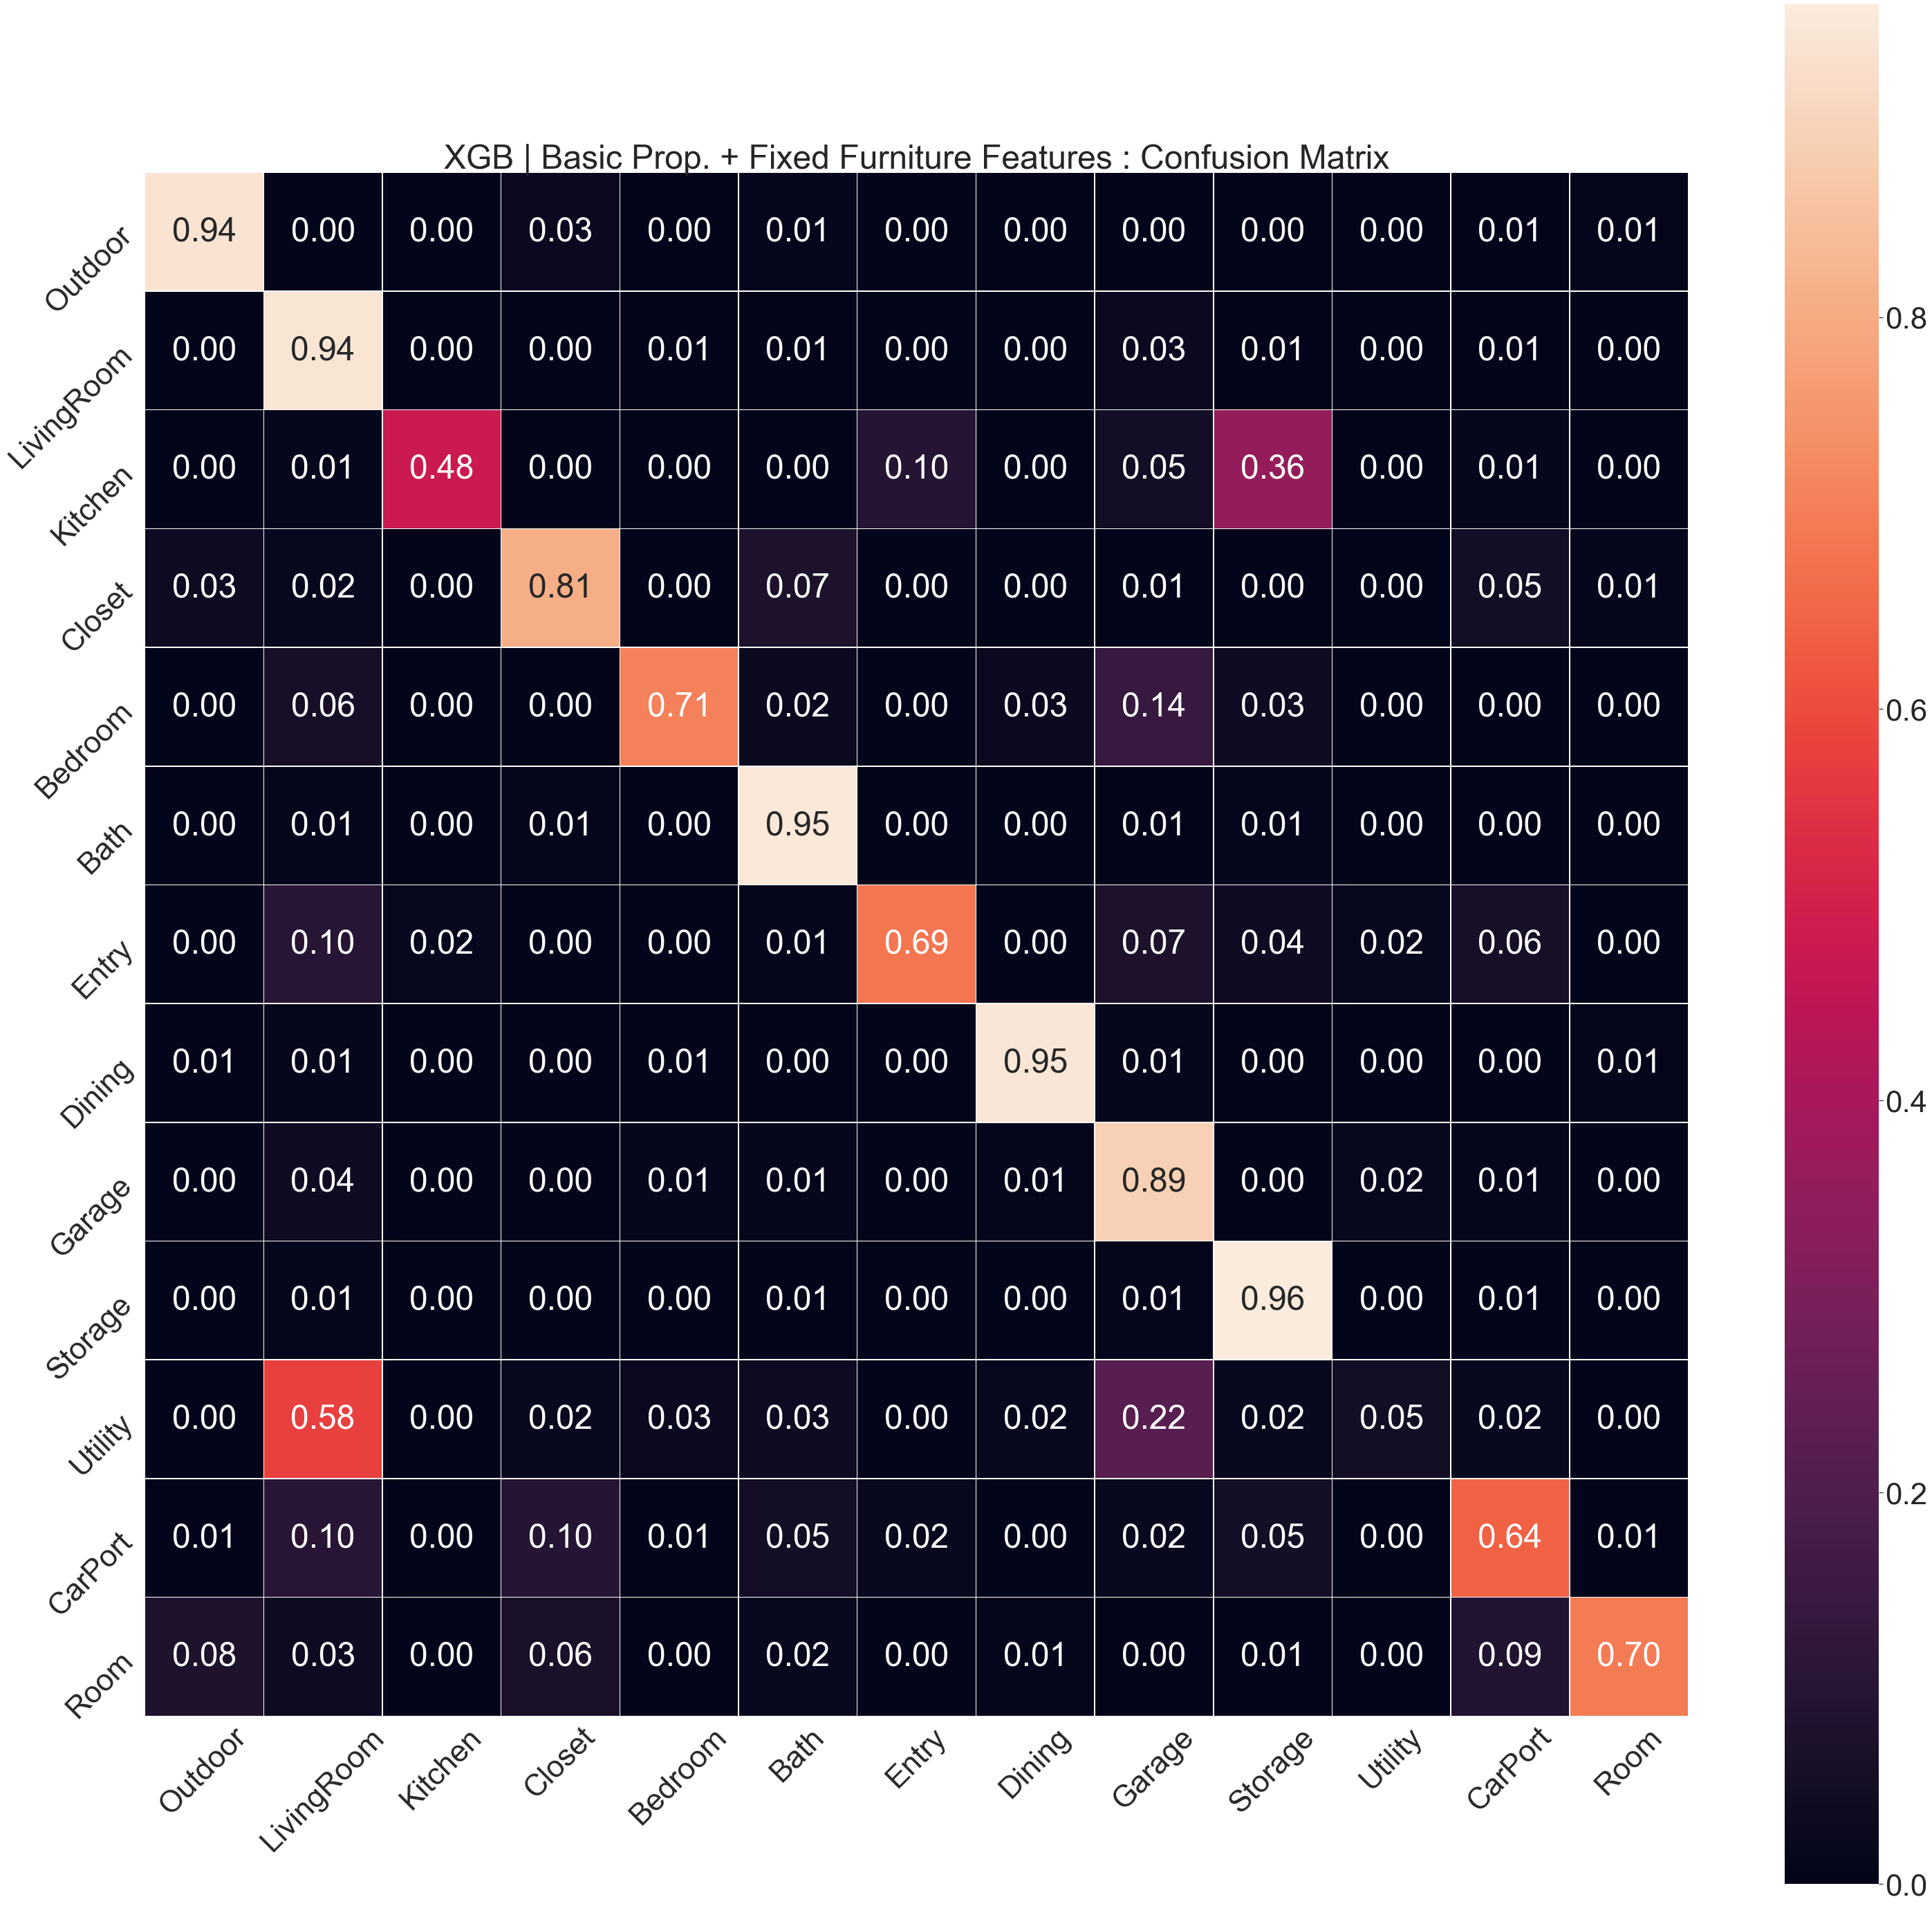

In [15]:
file_name = "XGB_Tier2b_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_2b)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_2b).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f",linewidths=.5 , square= True)
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('XGB | Basic Prop. + Fixed Furniture Features : Confusion Matrix')
sns.set(font_scale=4)
plt.savefig(fig_PATH, dpi=300, bbox_inches = 'tight')
plt.show()

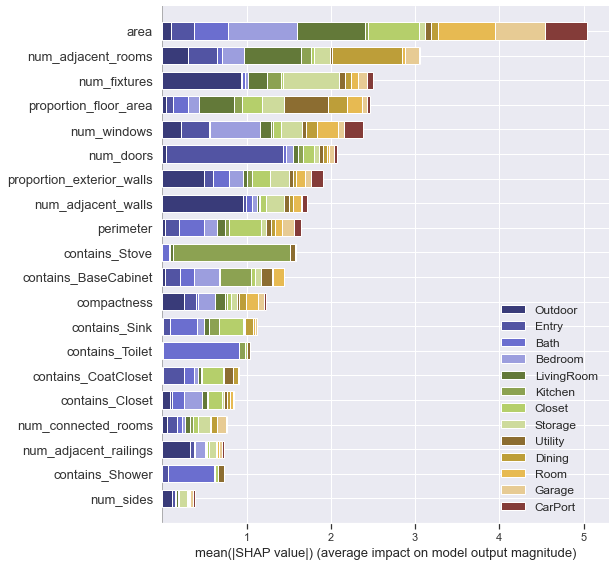

In [11]:
# Feature importance
file_name = "XGB_Tier2B_feat_imp.png"
fig_PATH = join(img_PATH,file_name)
explainer = shap.TreeExplainer(model_2b)
shap_values = explainer.shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,
                  plot_type="bar",class_names=model_2b.classes_,
                  title='XGB | Basic Properties + Fixed Furniture Features',
                  color = plt.get_cmap("tab20b"))
f.savefig(fig_PATH, bbox_inches='tight', dpi=300)

## Tier 3

2	validation_0-merror:0.06999	validation_1-mlogloss:0.37010	validation_1-merror:0.10964
[306]	validation_0-mlogloss:0.24423	validation_0-merror:0.06969	validation_1-mlogloss:0.36983	validation_1-merror:0.10919
[307]	validation_0-mlogloss:0.24370	validation_0-merror:0.06969	validation_1-mlogloss:0.36953	validation_1-merror:0.10919
[308]	validation_0-mlogloss:0.24310	validation_0-merror:0.06969	validation_1-mlogloss:0.36922	validation_1-merror:0.10905
[309]	validation_0-mlogloss:0.24262	validation_0-merror:0.06962	validation_1-mlogloss:0.36898	validation_1-merror:0.10875
[310]	validation_0-mlogloss:0.24214	validation_0-merror:0.06954	validation_1-mlogloss:0.36873	validation_1-merror:0.10890
[311]	validation_0-mlogloss:0.24160	validation_0-merror:0.06932	validation_1-mlogloss:0.36839	validation_1-merror:0.10875
[312]	validation_0-mlogloss:0.24107	validation_0-merror:0.06921	validation_1-mlogloss:0.36810	validation_1-merror:0.10875
[313]	validation_0-mlogloss:0.24051	validation_0-merror:0.

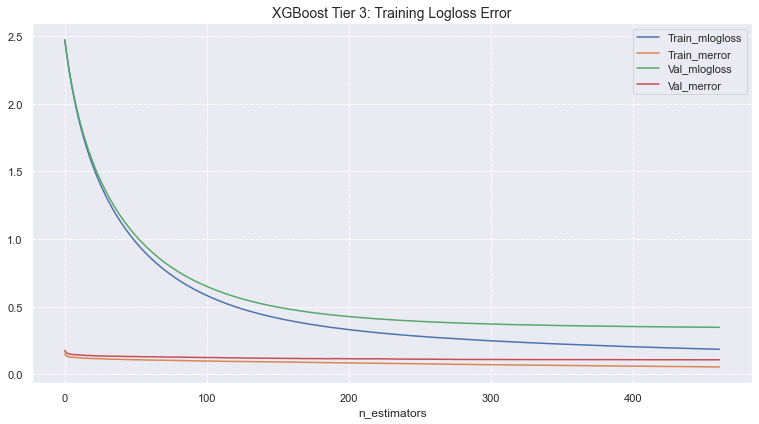

In [57]:
##TIER 3
#Train
X_train = X_train_train
y_train = y_train_train['type_cleaned']
#Validation
X_val = X_train_val
y_val = y_train_val['type_cleaned']
#Test
X_test = X_test_test
y_test = y_test_test['type_cleaned']

# Best params: {'colsample_bytree': 0.8, 'max_depth': 7, 'subsample': 0.6}
#XGB default parameters
model_3 = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 575,
                    max_depth = 7,
                    subsample= 0.6,
                    colsample_bytree = 0.8,
                    n_jobs = -1,
                    seed = 27)
print(model_3)

## Train Model
model_3.fit(X_train,y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

## Evaluate results
evals_result_3 = model_3.evals_result()
# Train score : Mean Accuracy
train_score_3 = model_3.score(X_train,y_train)
print("Tier 3 Training score: ",train_score_3)

best_iteration_3 = model_3.get_booster().best_ntree_limit
y_pred_3 = model_3.predict(X_test, ntree_limit=best_iteration_3)
print("Best Iteration: ",best_iteration_3)
# evaluate predictions
accuracy_3 = accuracy_score(y_test, y_pred_3)
print("Accuracy: %.2f%%" % (accuracy_3 * 100.0))

# Report Classification Results
file_name = "XGB_Tier3_classificationReport.csv"
report_PATH = join(res_PATH,file_name)
class_report = classification_report(y_test,y_pred_3,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_3))

#Mlogloss and Merror plot
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_axes([.1,.1,1,1])
file_name = "XGB_Tier3_mlogloss.png"
fig_PATH = join(img_PATH,file_name)
ax3.plot(evals_result_3.get('validation_0').get('mlogloss'), label='Train_mlogloss')   # Train set_mlogloss
ax3.plot(evals_result_3.get('validation_0').get('merror'), label='Train_merror')     # Train set_merror
ax3.plot(evals_result_3.get('validation_1').get('mlogloss'),label='Val_mlogloss')   #Val set_mlogloss
ax3.plot(evals_result_3.get('validation_1').get('merror'),label='Val_merror')     #Val set_merror
ax3.set_title('XGBoost Tier 3: Training Logloss Error', fontsize = 14)
ax3.legend(loc=1)
ax3.set_xlabel('n_estimators')
plt.grid(True, linestyle="--")
sns.set(font_scale=1)
fig3.savefig(fig_PATH)
plt.show()

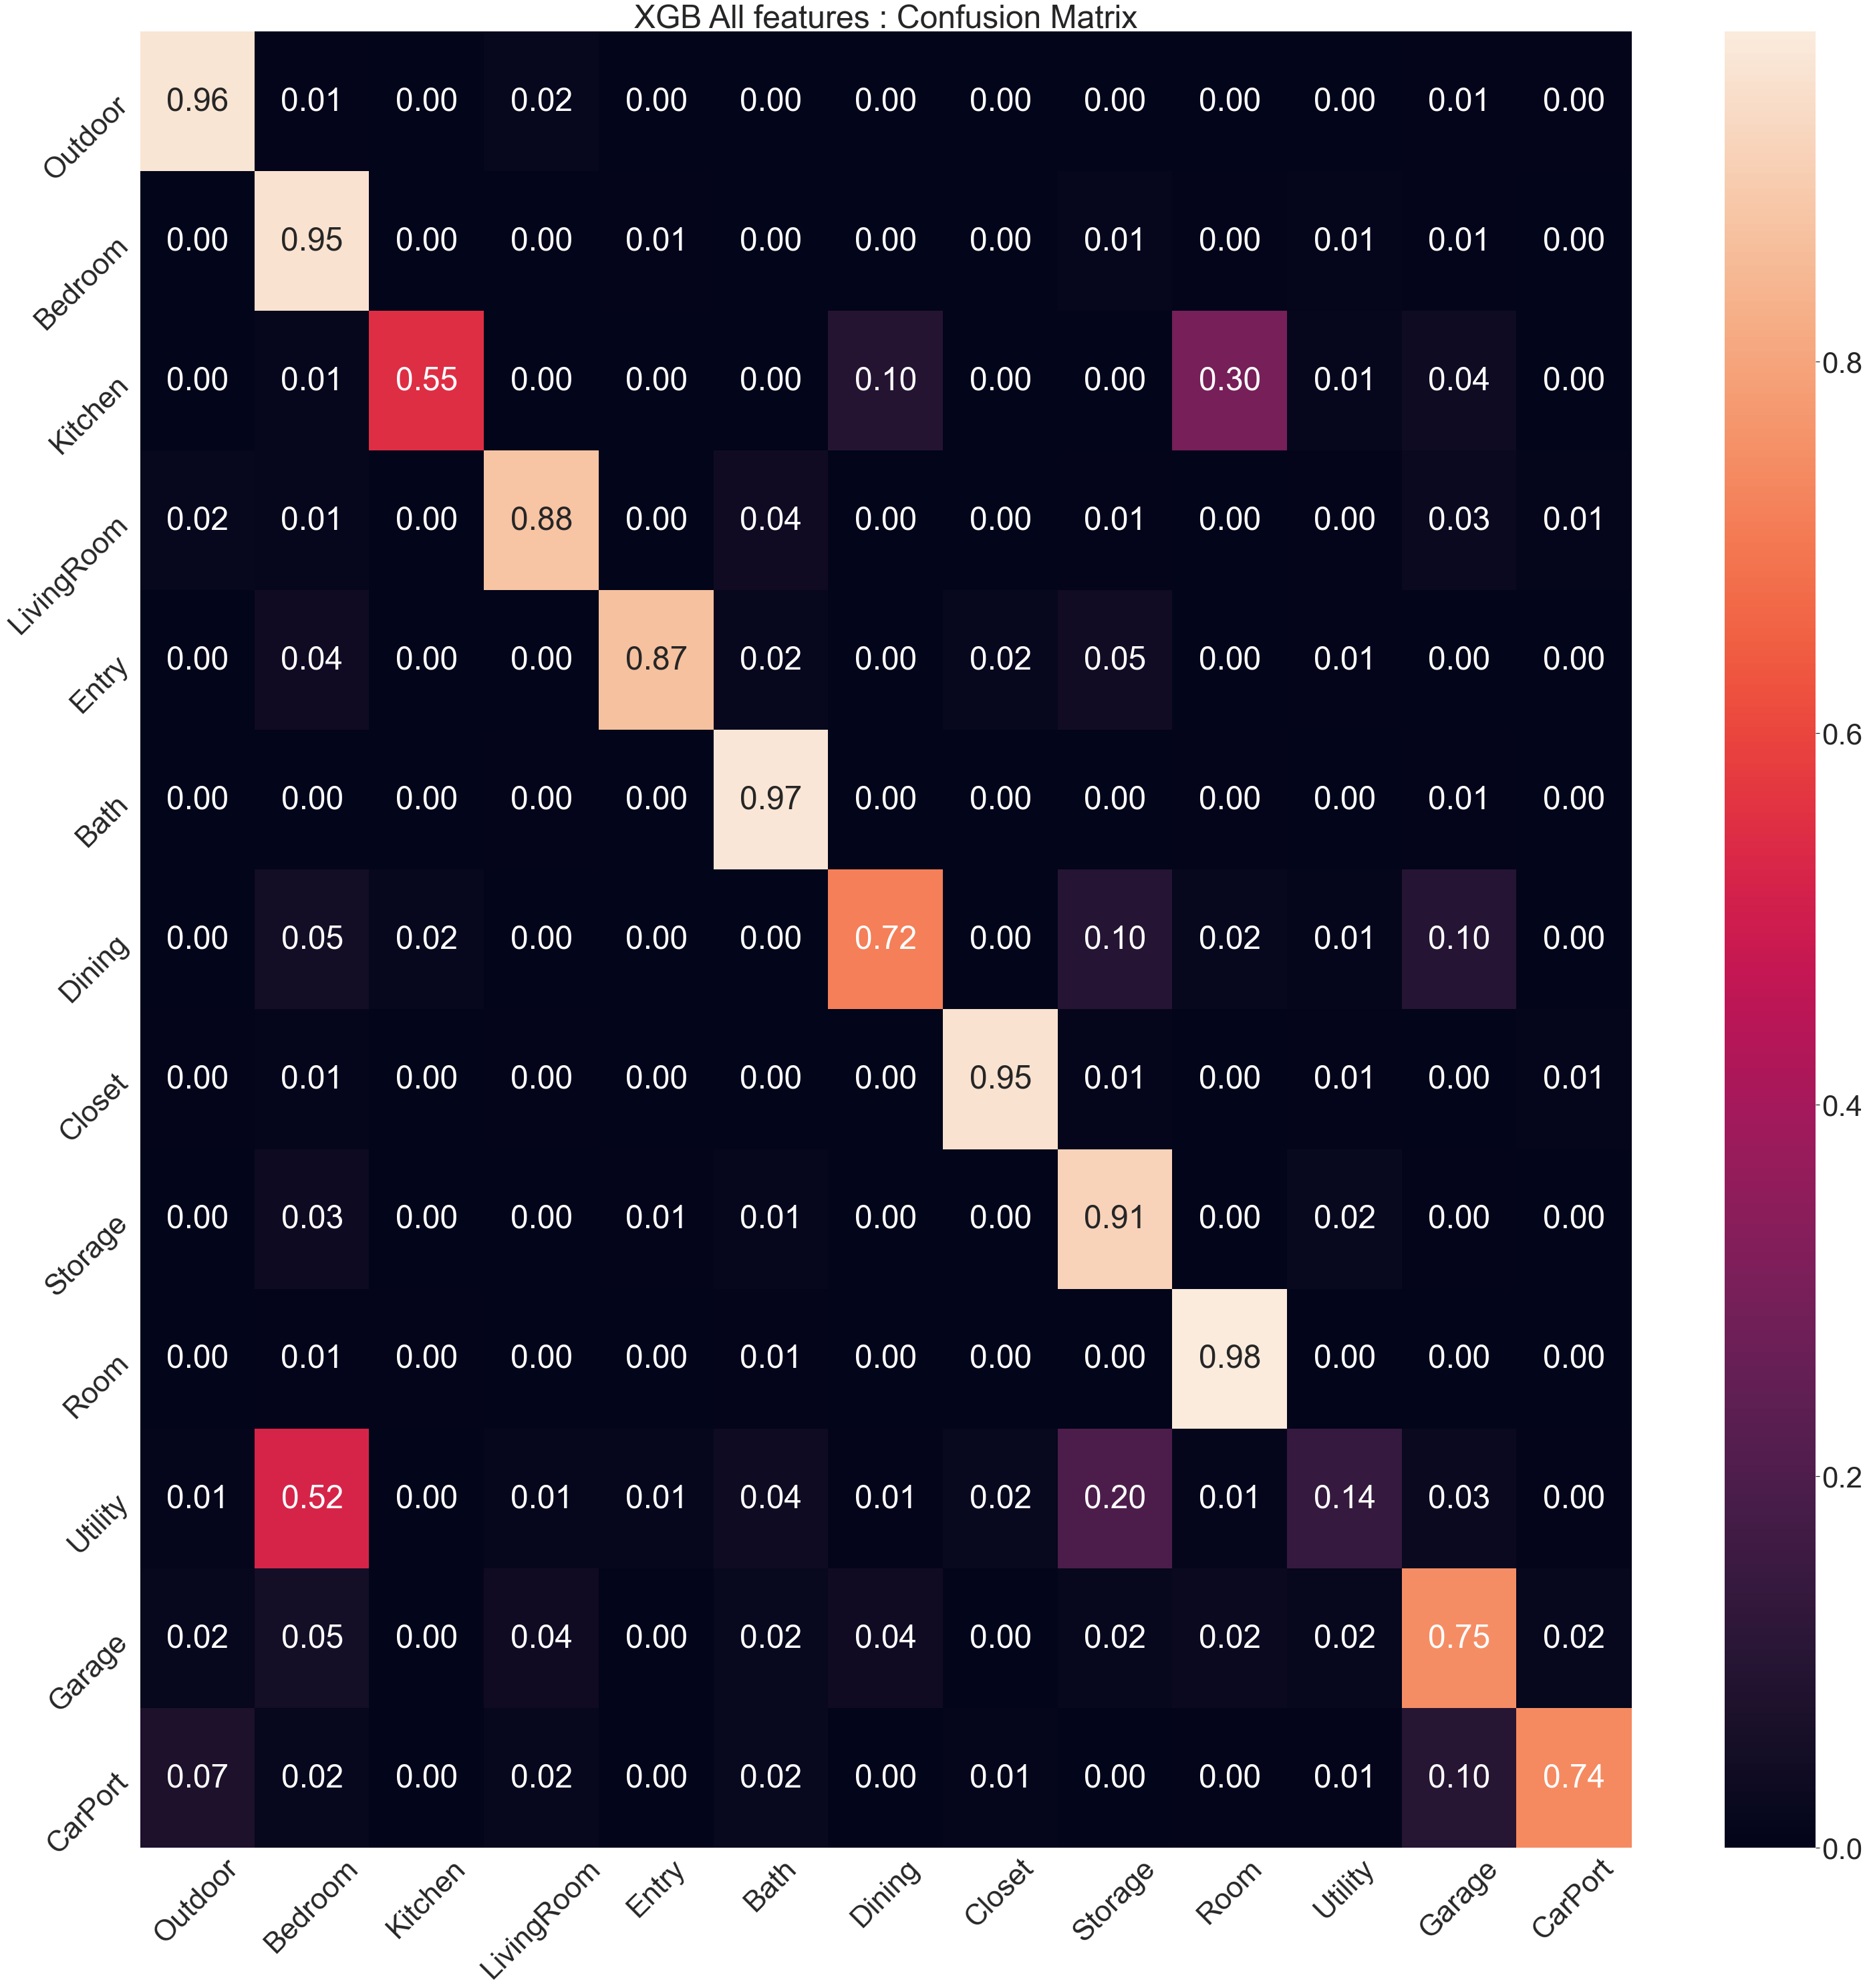

In [59]:
file_name = "XGB_Tier3_ConfMat.png"
fig_PATH = join(img_PATH,file_name)
cMat = confusion_matrix(y_test,y_pred_3)
df_cm = pd.DataFrame(data = matNorm(cMat) , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred_3).fillna(0).unique())
plt.figure(figsize= (50,50))
cm_fig = sns.heatmap(df_cm, annot=True, fmt=".2f")
cm_fig.set_xticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
cm_fig.set_yticklabels(cm_fig.get_xmajorticklabels(), rotation = 45)
plt.title('XGB All features : Confusion Matrix')
sns.set(font_scale=4)
plt.savefig(fig_PATH, dpi=300)
plt.show()

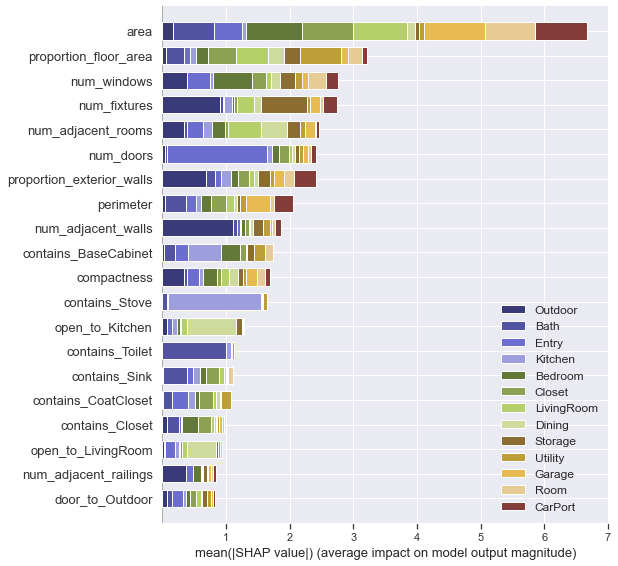

In [60]:
# Feature importance
file_name = "XGB_Tier3_feat_imp.png"
fig_PATH = join(img_PATH,file_name)
shap_values = shap.TreeExplainer(model_3).shap_values(X_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train,
                  plot_type="bar",class_names=model_3.classes_,
                  title='XGB All Features: Feature Importance',
                  color = plt.get_cmap("tab20b"))
f.savefig(fig_PATH, bbox_inches='tight', dpi=300)

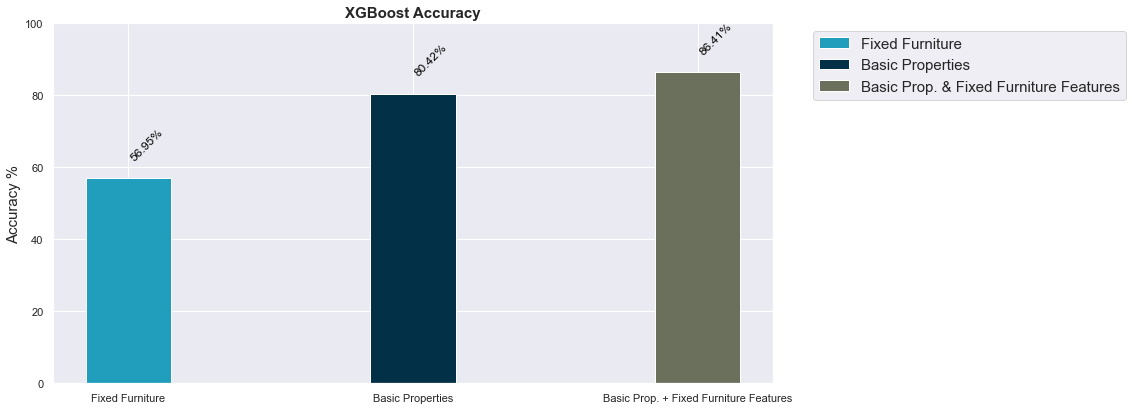

In [15]:
## Accuracy Comparison
sns.set(font_scale=1)
file_name = "XGB_acu.png"
fig_PATH = join(img_PATH,file_name)
fig_acu = plt.figure(figsize=(10,5))
ax_acu = fig_acu.add_axes([0.1,0.1,1,1])
ax_acu.bar(x='Fixed Furniture', height = accuracy_1b*100,width=0.3, label='Fixed Furniture', color='#219ebc')
ax_acu.bar(x='Basic Properties', height = accuracy_1c*100,width=0.3, label='Basic Properties', color='#023047')
ax_acu.bar(x='Basic Prop. + Fixed Furniture Features', height = accuracy_2b*100,width=0.3, label='Basic Prop. & Fixed Furniture Features', color='#6b705c')
# Values
ax_acu.set_title('XGBoost Accuracy', fontsize=15,fontweight = 'bold')
ax_acu.set_ylim(0,100)
ax_acu.legend(bbox_to_anchor=(1.5,1),loc = 'upper right', fontsize=15)
ax_acu.set_ylabel('Accuracy %', fontsize=15)

ax_acu.text('Fixed Furniture', accuracy_1b*100+5, "%.2f%%" % (accuracy_1b * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Basic Properties', accuracy_1c*100+5, "%.2f%%" % (accuracy_1c * 100.0), color='black', rotation=45, fontsize=12)
ax_acu.text('Basic Prop. + Fixed Furniture Features', accuracy_2b*100+5, "%.2f%%" % (accuracy_2b * 100.0), color='black', rotation=45, fontsize=12)

fig_acu.savefig(fig_PATH,dpi=300, bbox_inches = 'tight')